In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, Latex, Markdown
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os
import json
import pandas as pd

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [4]:
from masa_utils import sci_latex
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton, DDR_f, DDC_f, DDP_r_f
from masa_utils_pytorch import Optimization, TorchHelper
 

In [5]:
res0= 0.3
res_ref = 0.3
eta= 0.5
expc= 0.6
tau= 1.0e-2 #0.001
taupel = tau
parm_true = TorchHelper.to_tensor_r([np.log(res0), eta, np.log(taupel), expc])
param_text = fr"$\rho_0$: {res0: .2e} $\eta$: {eta: .2e}, $\tau_\rho$: {taupel: .2e}, $\mathrm{expc}$: {expc: .2e}"


In [7]:
param_text

'$\\rho_0$:  3.00e-01 $\\eta$:  5.00e-01, $\\tau_\\rho$:  1.00e-02, $\\mathrm0.6$:  6.00e-01'

In [8]:
freq_start_log = -1
freq_end_log = 5
freq_step_log = 0.1
nfreq= int((freq_end_log - freq_start_log) / freq_step_log) + 1
freq_1 = np.logspace(freq_start_log, freq_end_log, nfreq)

freq_start_log = 1
freq_end_log = 4
nfreq = int((freq_end_log - freq_start_log) / freq_step_log) + 1
freq_2 = np.logspace(freq_start_log, freq_end_log, nfreq)


In [9]:
IP_model = Pelton(freq=freq_1)
sim_1 = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
dobs_1 = np.abs(sim_1.ip_model.f(parm_true).detach())

IP_model = Pelton(freq=freq_2)
sim_2 = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
dobs_2 = np.abs(sim_2.ip_model.f(parm_true).detach())

C:\Users\81805\AppData\Local\Temp\ipykernel_18164\1864383523.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dobs_1 = np.abs(sim_1.ip_model.f(parm_true).detach())
C:\Users\81805\AppData\Local\Temp\ipykernel_18164\1864383523.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dobs_2 = np.abs(sim_2.ip_model.f(parm_true).detach())


In [11]:
texts = [
    r"$\| \rho(\min(f_{\mathrm{band},1})) \|$",
    r"$\| \rho(\max(f_{\mathrm{band},1})) \|$",
    r"$\| \rho(\min(f_{\mathrm{band},2})) \|$",
    r"$\| \rho(\max(f_{\mathrm{band},2})) \|$",
]

texts_xy = []

texts_xy.append(np.r_[freq_1[0], dobs_1[0].abs().item()])
texts_xy.append(np.r_[freq_1[-1], dobs_1[-1].abs().item()])
texts_xy.append(np.r_[freq_2[0], dobs_2[0].abs().item()])
texts_xy.append(np.r_[freq_2[-1], dobs_2[-1].abs().item()])

In [13]:
print(sci_latex(freq_1[0]))

$1.00\cdot 10^{-1}$


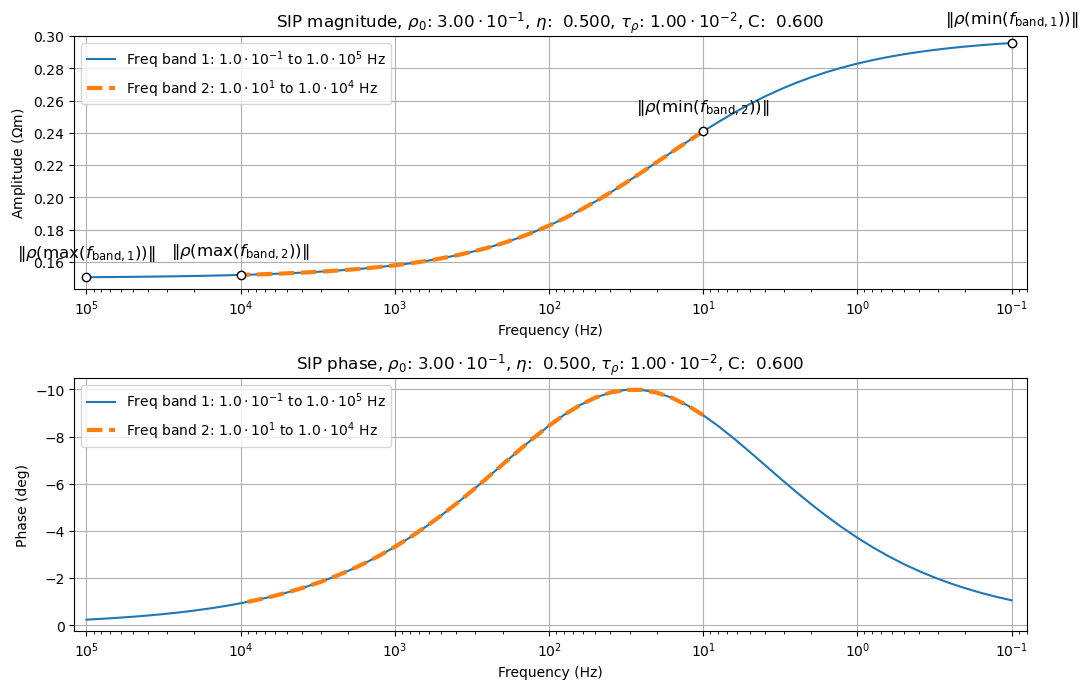

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(11,7))

ax = sim_1.plot_sip_model(parm_true, ax=ax,
    color='C0', 
    label=fr'Freq band 1: {sci_latex(freq_1[0], prec=1)} to {sci_latex(freq_1[-1], prec=1)} Hz')
ax = sim_2.plot_sip_model(parm_true, ax=ax,
    color='C1', linestyle='--', linewidth=3, 
    label=fr'Freq band 2: {sci_latex(freq_2[0], prec=1)} to {sci_latex(freq_2[-1], prec=1 )} Hz')
for i, s in enumerate(texts):
    x, y = texts_xy[i]

    # marker at the point
    ax[0].plot(
        x, y,
        marker="o",
        markersize=6,
        markeredgecolor="k",
        markerfacecolor="white",
        zorder=5,
    )

    # annotation
    ax[0].annotate(
        s,
        xy=(x, y),
        xycoords="data",
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        va="bottom",
        fontsize=12,
    )


ax[1].invert_yaxis()
ax[0].set_ylim(top=res0)
for a in ax:
    a.grid()
    a.legend()
    a.set_xlim(left=1.2e5, right=0.8e-1) 
ax[0].set_title(fr"SIP magnitude, $\rho_0$: {sci_latex(res0, prec=2)}, $\eta$: {eta: .3f}, $\tau_\rho$: {sci_latex(taupel, prec=2)}, C: {expc: .3f}")
ax[1].set_title(fr'SIP phase, $\rho_0$: {sci_latex(res0, prec=2)}, $\eta$: {eta: .3f}, $\tau_\rho$: {sci_latex(taupel, prec=2)}, C: {expc: .3f}')

plt.tight_layout()
plt.savefig("10_SIP_band12.pdf", bbox_inches="tight")
# or
plt.savefig("10_SIP_band12.jpg", dpi=300)     # JPG